# Q-Learning Example on Frozen Lake (Discrete Actions)


Basic concepts of Reinforcement Learning

Classical Reinforcement Learning algorithm called **Q-Learning** and apply this algorithm on the FrozenLake environment https://gym.openai.com/envs/FrozenLake-v0/

Let us first take a look at the game and start with the necessary imports

# Import Libraries

In [1]:
#%matplotlib notebook
%matplotlib inline
from IPython.display import clear_output
import time  # slow the game down a little bit
import gym
import numpy as np  # used for all kinds of matrix / vector operations
import matplotlib.pyplot as plt  # for plotting

----
-----

# PART 1: 
# Setting upFrozen Lake Environment

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:

    SFFF       (S: starting point, safe)
    FHFH       (F: frozen surface, safe)
    FFFH       (H: hole, fall to your doom)
    HFFG       (G: goal, where the frisbee is located)


The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

Link to Environment: https://gym.openai.com/envs/FrozenLake-v0/

We will be removing "slippery" from the environment, so there is no randomness to the direction.

More info: https://github.com/openai/gym/issues/565

And finally, depending on your computer specs or patience, you can scale the size of the lake up or down:

https://stackoverflow.com/questions/55006689/how-to-generate-a-random-frozen-lake-map-in-openai

To keep things simply, we'll use the default 4by4 grid, but check out the link above if you're crazy enough to go to some huge N by N grid.  :)

In [2]:
# In case you wanted to manually setup your own N by N grid.

# from gym.envs.toy_text.frozen_lake import generate_random_map

# random_map = generate_random_map(size=3, p=0.5)


**Here we register a new environment, where is_slippery=False.**

In [3]:
from gym.envs.registration import register

try:
    register(
        id='FrozenLakeNotSlippery-v0', # make sure this is a custom name!
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery': False},
        max_episode_steps=100,
        reward_threshold=.8196, # optimum = .8196
    )
except:
    print('You probably ran this cell twice, accidentally trying to register a new env with the same id twice.')
    print("Either change the id, or just continue, knowing your id was already registered")

**Let's run it with some random actions.**

Clear the output of the cell before writing the new state

In [4]:
from IPython.display import clear_output

In [5]:
env = gym.make("FrozenLakeNotSlippery-v0")  # Load FrozenLake
observation = env.reset()  # Reset to initial state
for epsiode in range(4):
    print(observation)
    env.render()  # Render on the screen
    time.sleep(0.2)
    clear_output(wait=True)
    action = env.action_space.sample()  # chose a random action
    observation, reward, done, info = env.step(action)  # Perform random action on the environment
    
env.close()  # dont forget to close the environment

4
  (Down)
SFFF
FHFH
FFFH
HFFG


Let us take a look at the possible actions.
You can find them here: https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

As we can see, there is just 1 observation, a single digit representing the current location, for a 4by4 "lake":

    0    1   2  3
    4    5   6  7
    8    9  10  11
    12  13  14  15

and four actions:

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3

# PART 2: 
# Creating the Q-Learning Table

Now that we validated the functionality of our function it is time to move on with the Q-Learning algorithm. 

Recall our Table is essentially a mapping of all possible state,action pairs and the expected reward for taking an action at a particular state that we will keep updating.


$$Q(s_t,a_t)$$

For our simple discrete Frozen Lake problem, this means we have 4 actions for columns, and 16 possible states (player location on the 4 by 4 grid). So our table will look like:

<table style="width:100%">
  <tr>
      <th></th>
    <th>A0 - LEFT</th>
    <th>A1 - DOWN</th>
    <th>A2 - RIGHT</th>
    <th>A3 - UP</th>
  </tr>
  <tr>
    <td><strong>State 0</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
      <td>Q(s,a)</td>
      <td>Q(s,a)</td>
  </tr>
  <tr>
      <td><strong>State 1</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
      <td>Q(s,a)</td>
  </tr>
    <tr>
      <td><strong>State ...</strong></td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
        <td>...</td>
  </tr>
    <tr>
      <td><strong>State 15</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
        <td>Q(s,a)</td>
  </tr>
</table>

In [6]:
action_size = env.action_space.n
state_size = env.observation_space.n

## Initial Q-Table

In [7]:
# Start with very small values for all our Q(s,a)
q_table = np.zeros([state_size, action_size])

In [8]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [9]:
q_table.shape

(16, 4)

# PART 3:
# Hyperparameters

**The Q-Learning update functions will require hyperparameters. we'll define them here. Often the best place to choose a good starting value is reading publications or through experimentation. Unfortunately, its very difficult to give general advice, as most environments are radically different to each other, and often hyperparameter tuning is required.**

**Q-Learning Equation Parameters: https://en.wikipedia.org/wiki/Q-learning**

In [10]:
# It is common to leave Hyperparameters in ALL CAPS to easily locate them

EPOCHS=20000  # number of epochs/episodes to train for
ALPHA = 0.8 # aka the learning rate
GAMMA = 0.95 # aka the discount rate
# MAX_EPISODES = 100  # optional, also defined in env setup above

**Exploration vs. Exploitation Parameters**

Basically how fast do we reduce epsilon. Reduce too fast, agent won't have enough time to learn. Reduce too slow, you're wasting time picking random actions. Key here is that these value help balance exploration (random choice) versus explotation (always picking what works for that Q(s,a). It's a tough balance!

In [11]:
# Exploration vs. Exploitation parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001             # Exponential decay rate for exploration prob

# PART 4:
# Q-Table Update Functions Methodology

-----

## Now it is time to dive into the training / Q-Table update methodology.<br />
First we will define some functions needed for training phase

* epsilon_greedy_action_selection: Is used to implement the epsilon greedy action selection routine.
* compute_next_q_value: Computes the next Q-Values according to the formula from the lecture
* reduce_epsilon: Reduces the $\epsilon$ used for the epsilon greedy algorithm

**FUNCTION TO SELECT AN ACTION**

If we simply always select the argmax() qtable value during training, we'll most likely get stuck in an explotation loop, so we'll use a random value to randomly select an action from time to time, helping the model explore , rather than exploit.

In [12]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    '''
    Returns an action for the agent. Note how it uses a random number to decide on
    exploration versus explotation trade-off.
    '''
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:
        # Action row for a particular state
        state_row = q_table[discrete_state,:]
        # Index of highest action for state
        # Recall action is mapped to index (e.g. 0=LEFT, 1=DOWN, etc..)
        action = np.argmax(state_row)
    
    # EXPLORATION, USE A RANDOM ACTION
    else:
        # Return a random 0,1,2,3 action
        action = env.action_space.sample()
        
    return action

**FUNCTION FOR Q_VALUE COMPUTATION**

**Here we have our main Q-Learning update equation, note how it takes in the old q-value, the next optimal q value, along with our current reward, and then updates the next q value accordingly.**

In [13]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

**FUNCTION TO REDUCE EPSILON**

**As training continues, we need to balance explotation versus exploration, we want ot make sure our agent doesn't get trapped in a cycle going from an F square to another F Square back and forth. We also don't want our agent permanently choosing random values. We'll use the function below to try to balance this.**

In [14]:
def reduce_epsilon(epsilon,epoch):
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)

# PART 5:
# Training of Agent and Updating Q-Table

If you plan on plotting your training progress, make sure to put this all in the same cell, otherwise matplotlib may not connect to the training loop and just show an empty plot.

In [15]:
# Reset just in case, watch lecture on this.
q_table = np.zeros([state_size, action_size])
total_reward = 0
epsilon = 1

In [16]:
EPOCHS

20000

In [17]:
# List of rewards
rewards = []

# Play 20k games
for episode in range(EPOCHS):
    # Reset the environment
    state = env.reset()
    done = False
    total_rewards = 0
    
    while not done:
        action = epsilon_greedy_action_selection(epsilon,q_table, state)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)
   
        # Look up current/old qtable value Q(s_t,a_t)
        old_q_value =  q_table[state,action]  

        # Get the next optimal Q-Value
        next_optimal_q_value = np.max(q_table[new_state, :])  

        # Compute next q value
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)   

        # Update Q Table
        q_table[state,action] = next_q
        
        total_rewards = total_rewards + reward
        
        # Our new state is state
        state = new_state

    episode += 1
    # Reduce epsilon (because we need less and less exploration)
    epsilon = reduce_epsilon(epsilon,episode) 
    rewards.append(total_rewards)

env.close()

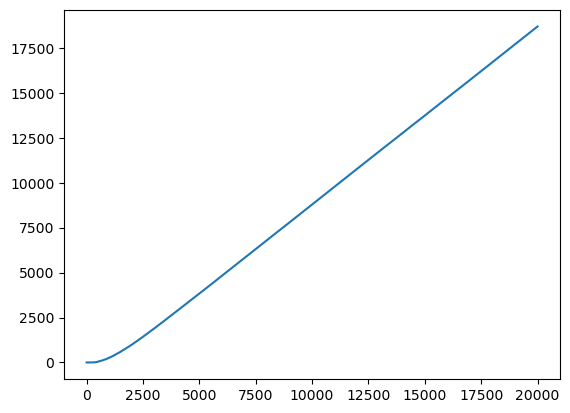

In [18]:
plt.plot(range(EPOCHS),np.cumsum(rewards))

In [19]:
q_table

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77353324, 0.77377978],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

## Training with Active Visualization

**Watch the training happen. This slows down training time since it visualizes each game, and we make it play 20k games.**

In [ ]:
# Reset just in case, watch lecture on this.
q_table = np.zeros([state_size, action_size])
total_reward = 0
epsilon = 1

In [ ]:
%matplotlib inline
##############################################
### VISUALIZATION OF TRAINING PROGRESS ######
#############################################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
log_interval = 1000 # Plot a new point every log_interval games, do NOT make this too small!
epoch_plot_tracker = []
total_reward_plot_tracker = []


###############################################
################################################
for episode in range(EPOCHS):
    # Reset the environment
    state = env.reset()
    done = False
    total_rewards = 0
    
    while not done:
        action = epsilon_greedy_action_selection(epsilon,q_table, state)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        
        # Look up current/old qtable value Q(s_t,a_t)
        old_q_value =  q_table[state,action]  

        # Get the next optimal Q-Value
        next_optimal_q_value = np.max(q_table[new_state, :])  

        # Compute next q value
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)   

        # Update Q Table
        q_table[state,action] = next_q
        
        # Our new state is state
        state = new_state
        
        
        #### Use Ctrl+/ to uncomment this block all at once.
        ########################################################################
        ########## OPTIONAL TABLE REPORTING AND DISPLAY #######################
        ######################################################################
        print(f"Epsilon is currently {epsilon}")
        print(f"Currently on Epoch {episode}, total reward earned so far is {total_reward}")
        print(f"Current state {state} and performing action {action}")
        env.render()
        print(q_table)
        
        time.sleep(0.01)
        clear_output(wait=True)
        
        ######################################################################
        ######################################################################
        ######################################################################

        
    episode += 1
    # Reduce epsilon (because we need less and less exploration)
    epsilon = reduce_epsilon(epsilon,episode) 
    
    total_reward += reward # Since +1 is only time reward is recorded, meaning game is also done
    total_reward_plot_tracker.append(total_reward)
    epoch_plot_tracker.append(episode)
    
    ################ Plot the points and running mean ##################
    if episode % log_interval == 0:
        ax.clear() 
        ax.plot(epoch_plot_tracker,total_reward_plot_tracker) 
        fig.canvas.draw()

  ######################################################################
        


env.close()

--------
---------

# PART 5:
# Using Learned Q Table Results

Now it is time for a final evaluation round!
Let's see how well our first RL agent performs

In [ ]:
state = env.reset()
rewards = 0
for _ in range(100):
    env.render()
    
    action = np.argmax(q_table[state])  # and chose action from the Q-Table
    state, reward, done, info = env.step(action) # Finally perform the action

    time.sleep(1)
    clear_output(wait=True)
    
    if done:
        break

env.render()
env.close()